## 라이브러리

In [1]:
from typing import List
from glob import glob
import os
import json
import pickle as pkl

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
import random

seed = 2023
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

## 데이터 로드

In [3]:
with open('/content/dlib_img_data_train.pkl', 'rb') as f:
    img_data_train = pkl.load(f)

with open('/content/labels_train.pkl', 'rb') as f:
    lab_data_train = pkl.load(f)

with open('/content/dlib_img_data_test.pkl', 'rb') as f:
    img_data_test = pkl.load(f)

with open('/content/labels_test.pkl', 'rb') as f:
    lab_data_test = pkl.load(f)

In [4]:
print(len(img_data_train))
print(len(img_data_test))

1000
200


## 데이터파라미터 세팅

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"현재 사용하는 디바이스: {device}")

현재 사용하는 디바이스: cuda


In [6]:
timesteps = 16
n_labels = 10
n_transform = 5
img_col = 45
img_row = 30
img_channel = 1
batch_size = 32

## 데이터셋 구축

In [7]:
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((30, 45),scale=(0.9,1.1)),
])

In [30]:
candidate_data_transform = transforms.Compose([
    transforms.RandomResizedCrop((30, 45),scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
])

In [31]:
class LipReadingDataset(Dataset):
    def __init__(self, img_data:List[List[np.ndarray]] , labels:List[int], frame_len:int = 15, n_labels:int = 10, transform=None, n_transform:int = 0)->None:

        assert len(img_data) == len(labels)
        scenes = []

        for frames in img_data:

            while frame_len > len(frames):
                frames.append(frames[-1])

            if frame_len < len(frames):
                frames = frames[:frame_len]

            scene = np.stack(frames, axis = 0)
            scenes.append(torch.from_numpy(scene / 255.0).float())

        if transform:
            temp_scenes = scenes
            temp_labels = labels

            scenes = []
            labels = []

            for _ in range(n_transform):
                for sc, lb in zip(temp_scenes, temp_labels):
                    scenes.append(transform(sc))
                    labels.append(lb)

        self.scenes = torch.unsqueeze(torch.stack(scenes, axis = 0), axis = 2)
        self.labels = F.one_hot(torch.from_numpy(np.array(labels) - 1), n_labels)

        print(self.scenes.shape, self.labels.shape)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        scene = self.scenes[idx]
        label = self.labels[idx]

        return scene, label

In [32]:
train = LipReadingDataset(img_data_train, lab_data_train, timesteps, n_labels, data_transform, n_transform)
test = LipReadingDataset(img_data_test, lab_data_test, timesteps, n_labels)

torch.Size([5000, 16, 1, 30, 45]) torch.Size([5000, 10])
torch.Size([200, 16, 1, 30, 45]) torch.Size([200, 10])


In [38]:
cv2_imshow(train[51][0][2][0].numpy() * 255)

In [39]:
print(train[0][0].dtype)

torch.float32


In [40]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

## 모델 정의

In [41]:
class SimpleLipNet(nn.Module):
    def __init__(self, video_shape, vocabulary_size:int = 10):
        super(SimpleLipNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(128)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.conv3 = nn.Conv3d(128, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(32)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.flatten1 = nn.Flatten(2)

        lstm_input = 32 * (video_shape[1] // 8) * (video_shape[2] // 8)
        self.lstm1 = nn.LSTM(input_size=lstm_input, hidden_size=64, bidirectional=True, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, bidirectional=True, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)

        self.flatten2 = nn.Flatten()
        self.dense = nn.Linear(128 * (video_shape[0]), vocabulary_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.flatten1(x.transpose(1, 2))
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = self.flatten2(x)
        x = self.dense(x)
        x = self.softmax(x)
        return x

In [42]:
model = SimpleLipNet((timesteps, img_col, img_row), n_labels)
model = model.to(device)

## 모델 학습

In [43]:
Learning_rate = 0.0001
validation_ratio = 0.2
num_epochs = 50
max_lr = 0.001
pct_start= 0.2
weight_decay = 0.005

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=Learning_rate, weight_decay = weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr,
                                                epochs = num_epochs,
                                                steps_per_epoch=len(train_loader),
                                                pct_start=pct_start)

In [45]:
model.train()

loss_history = []
acc_history = []
lr_history = []

for epoch in range(num_epochs):

    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        scheduler.step()

        lr_history.append(scheduler.get_last_lr())

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == torch.max(labels, 1)[1])

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc.cpu())

    print('{}, Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

0, Loss: 2.3020 Acc: 0.1118
1, Loss: 2.3000 Acc: 0.1448
2, Loss: 2.2631 Acc: 0.2098
3, Loss: 2.1248 Acc: 0.3454
4, Loss: 2.0058 Acc: 0.4680
5, Loss: 1.9450 Acc: 0.5340
6, Loss: 1.8555 Acc: 0.6232
7, Loss: 1.8158 Acc: 0.6612
8, Loss: 1.8044 Acc: 0.6784
9, Loss: 1.7490 Acc: 0.7348
10, Loss: 1.7269 Acc: 0.7540
11, Loss: 1.7124 Acc: 0.7680
12, Loss: 1.6952 Acc: 0.7870
13, Loss: 1.6890 Acc: 0.7890
14, Loss: 1.6587 Acc: 0.8250
15, Loss: 1.6497 Acc: 0.8314
16, Loss: 1.6320 Acc: 0.8494
17, Loss: 1.6204 Acc: 0.8562
18, Loss: 1.6046 Acc: 0.8722
19, Loss: 1.5989 Acc: 0.8804
20, Loss: 1.5942 Acc: 0.8840
21, Loss: 1.5913 Acc: 0.8854
22, Loss: 1.5643 Acc: 0.9150
23, Loss: 1.5501 Acc: 0.9288
24, Loss: 1.5573 Acc: 0.9170
25, Loss: 1.5463 Acc: 0.9324
26, Loss: 1.5380 Acc: 0.9400
27, Loss: 1.5337 Acc: 0.9420
28, Loss: 1.5303 Acc: 0.9448
29, Loss: 1.5101 Acc: 0.9638
30, Loss: 1.5131 Acc: 0.9608
31, Loss: 1.5020 Acc: 0.9712
32, Loss: 1.4990 Acc: 0.9744
33, Loss: 1.4987 Acc: 0.9756
34, Loss: 1.4984 Acc: 0.

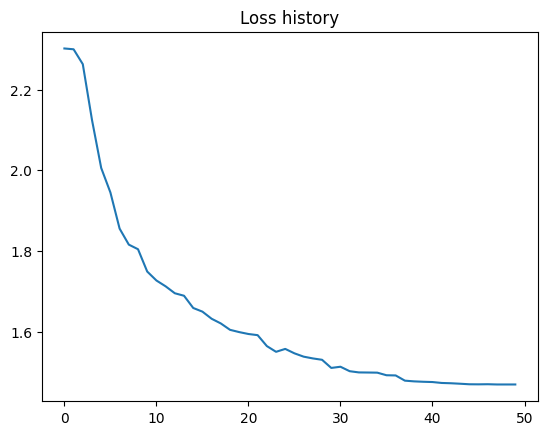

In [46]:
plt.title("Loss history")
plt.plot(list(range(num_epochs)), loss_history)
plt.show()

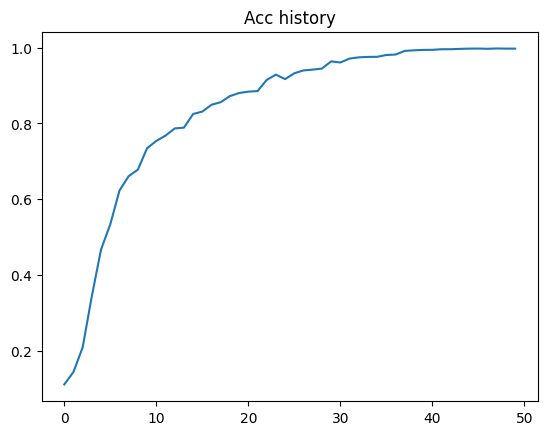

In [47]:
plt.title("Acc history")
plt.plot(list(range(num_epochs)), list(map(lambda x: x.cpu(), acc_history)))
plt.show()

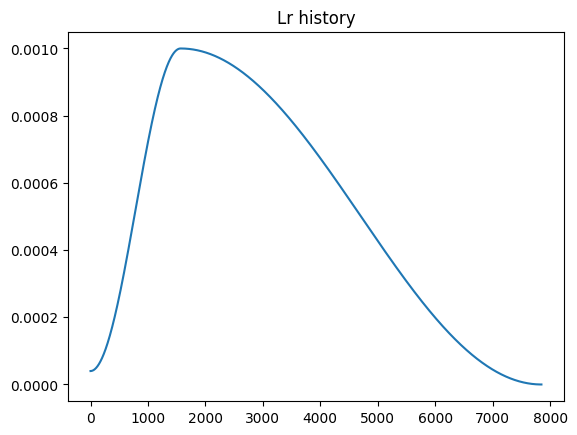

In [48]:
plt.title("Lr history")
plt.plot(lr_history)
plt.show()

In [49]:
model.eval()
running_corrects = 0

for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward Pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == torch.max(labels, 1)[1])

test_acc = running_corrects.double() / len(test_loader.dataset)
print('Test Acc: {:.4f}'.format(test_acc))

Test Acc: 0.6200


In [24]:
torch.save(model, '/content/dlib_model.pt')  # 전체 모델 저장
torch.save(model.state_dict(), '/content/dlib_model_state_dict.pt')  # 모델 객체의 state_dict 저장